In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import fastbootstrap as fb

plt.style.use("ggplot")

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is any test or metric that uses random sampling with replacement (e.g. mimicking the sampling process), and falls under the
broader class of resampling methods. Bootstrapping assigns measures of accuracy (bias, variance, confidence intervals, prediction error, etc.) to sample estimates. This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods.

Bootstrapping estimates the properties of an estimand (such as its variance) by measuring those properties when sampling from an approximating distribution. One standard choice for an approximating distribution is the empirical distribution function of the observed data. In the case where a set of observations can be assumed to be from an independent and identically distributed population, this can be implemented by constructing a number of resamples with replacement, of the observed data set (and of equal size to the observed data set).

It may also be used for constructing hypothesis tests. It is often used as an alternative to statistical inference based on the assumption of a parametric model when that assumption is in doubt, or where parametric inference is impossible or requires complicated formulas for the calculation of standard errors.

# Experiment 1

For example, let's generate two samples of the exponential distribution with similar $\beta$ parameter

In [2]:
n = 10000

sample_1 = np.random.exponential(scale=1 / 0.001, size=n)
sample_2 = np.random.exponential(scale=1 / 0.00101, size=n)
data_df = pd.DataFrame(
    {"sample_1": pd.Series(sample_1), "sample_2": pd.Series(sample_2)}
)

These samples have no significant difference in descriptive statistical parameters; let's check it in the experiment

<Axes: ylabel='Count'>

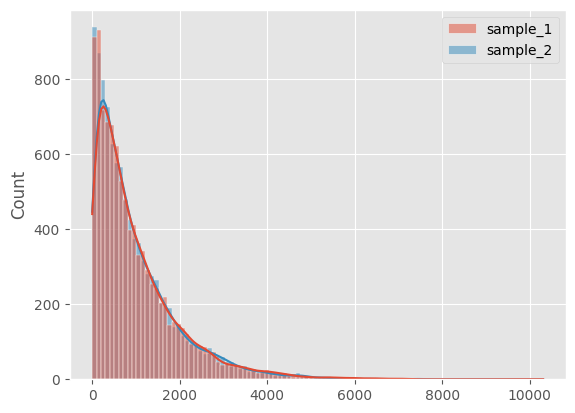

In [3]:
binwidth, bins = fb.estimate_bin_params(sample_1)
sns.histplot(data_df, binwidth=binwidth, bins=bins, kde=True)

The essence of this experiment is to conduct several experiments in which we will take subsamples with replacements from our samples. We will calculate the difference between the mathematical expectation of the two subsamples($M[subsample_1]-M[subsample_2]$) in every case and then build a histogram with the result of our experiments

In [4]:
stats = fb.two_sample_bootstrap(sample_1, sample_2, plot=False)
p_value = stats["p_value"]
stats

{'p_value': 0.1464,
 'statistic_value': -19.927692919188644,
 'confidence_interval': array([-47.32525307,   6.68917861]),
 'distribution': None}

CI(Confidence Interval) contains zero, which means we have no significant difference between the mean of the two samples

We can rephrase this statement:  In our subsample experiments, the difference between the means of our subsamples is zero in many cases

Estimated $p$_$value$ proves this statement:

In [5]:
fb.display_significance_result(p_value)

<div class="alert alert-block alert-danger">Difference is non-not significant (p-value >= 0.05)</div>

### Bootstrap recommendations:
1. To estimate 90% CI, the number of bootstrap iterations should be between 1000-2000 (boot_it=2000)
2. To estimate 95% CI, the number of bootstrap iterations should be greater or equal to 5000 (boot_it=5000)

#### Experiment 1.1

To estimate the difference in medians, we can use [Bootstrap created by the Spotify team](https://engineering.atspotify.com/2022/03/comparing-quantiles-at-scale-in-online-a-b-testing/), [Mårten Schultzberg](https://github.com/MSchultzberg), and [Sebastian Ankargren](https://github.com/ankargren)

Mårten Schultzberg and Sebastian Ankargren. “Resampling-free bootstrap inference for quantiles.” arXiv e-prints, art. arXiv:2202.10992, (2022). [Article link](https://arxiv.org/abs/2202.10992).

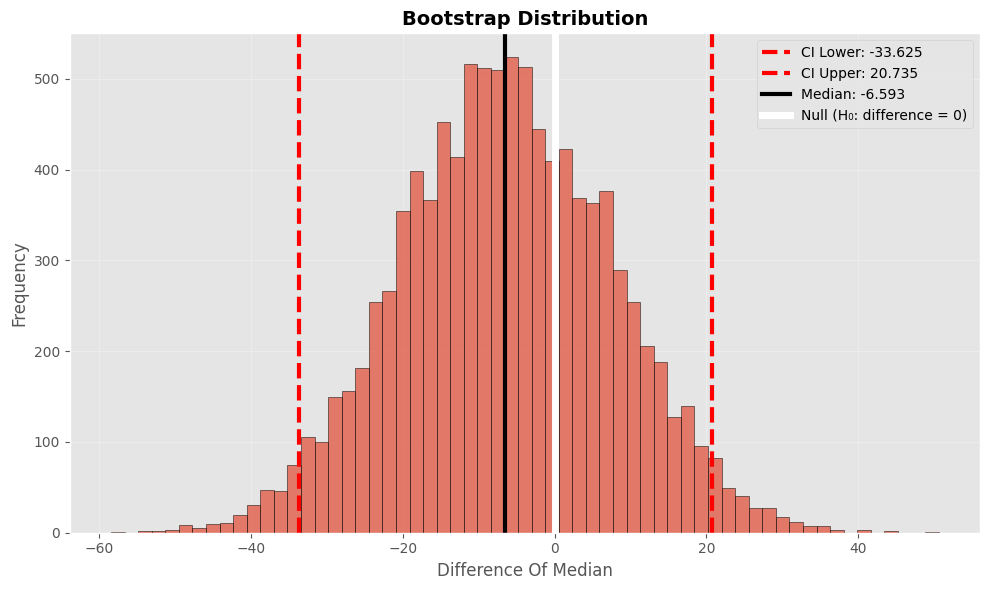

{'p_value': 0.6464,
 'statistic_value': -6.592930587132912,
 'confidence_interval': array([-33.62479379,  20.73492335]),
 'distribution': None}

In [6]:
stats = fb.two_sample_bootstrap(
    sample_1, sample_2, statistic=fb.difference_of_median, plot=True
)


p_value = stats["p_value"]
stats

In [7]:
fb.display_significance_result(p_value)

<div class="alert alert-block alert-danger">Difference is non-not significant (p-value >= 0.05)</div>

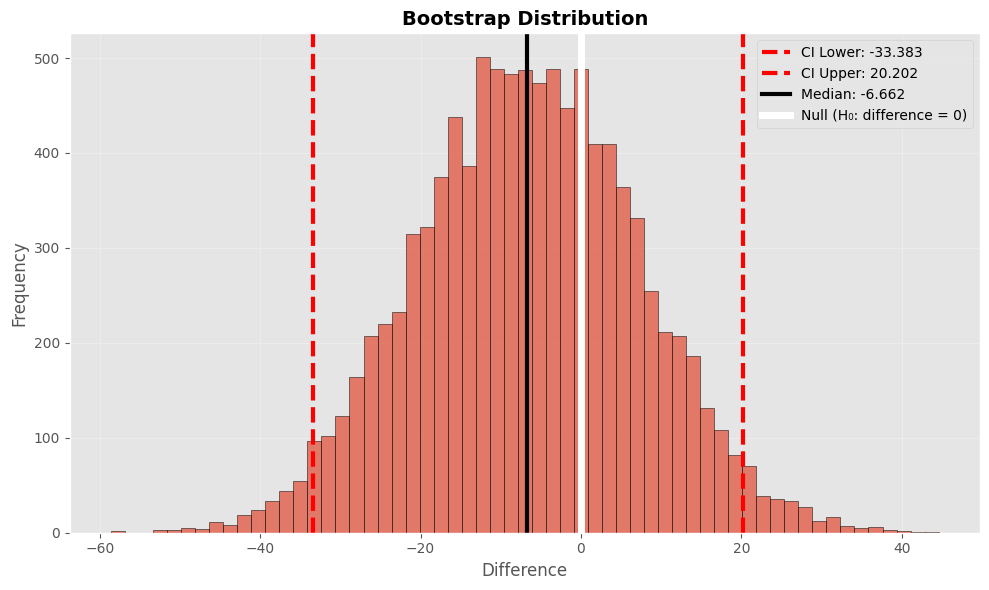

{'p_value': 0.6442,
 'statistic_value': -6.420647790234398,
 'confidence_interval': array([-33.38315364,  20.20249774]),
 'distribution': None}

In [8]:
stats = fb.spotify_two_sample_bootstrap(sample_1, sample_2, plot=True)
p_value = stats["p_value"]
stats

In [9]:
fb.display_significance_result(p_value)

<div class="alert alert-block alert-danger">Difference is non-not significant (p-value >= 0.05)</div>

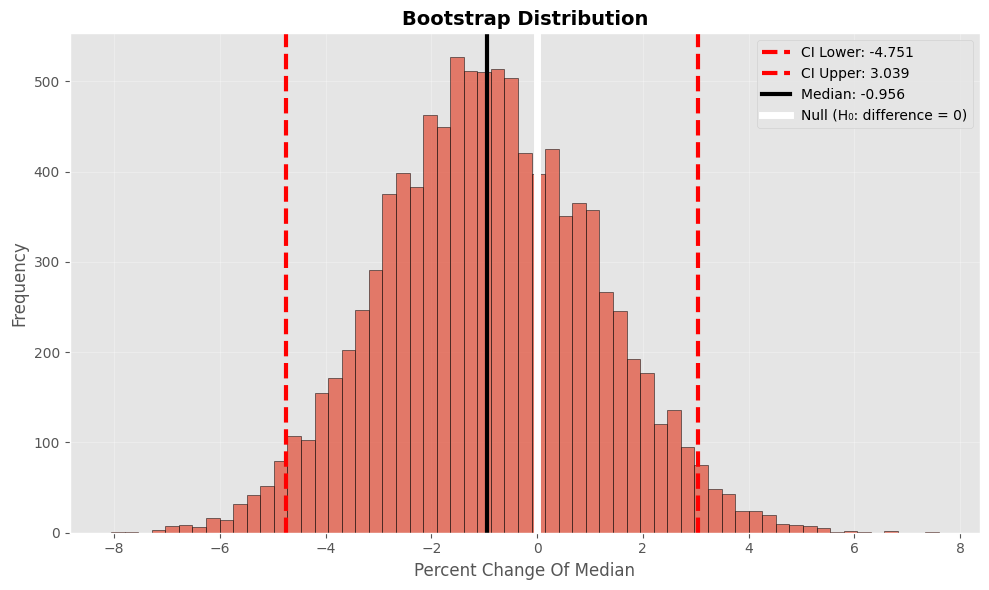

{'p_value': 0.6464,
 'statistic_value': -0.9560612172804483,
 'confidence_interval': array([-4.75143787,  3.03878194]),
 'distribution': None}

In [10]:
stats = fb.two_sample_bootstrap(
    sample_1, sample_2, statistic=fb.percent_change_of_median, plot=True
)
p_value = stats["p_value"]
stats

In [11]:
fb.display_significance_result(p_value)

<div class="alert alert-block alert-danger">Difference is non-not significant (p-value >= 0.05)</div>

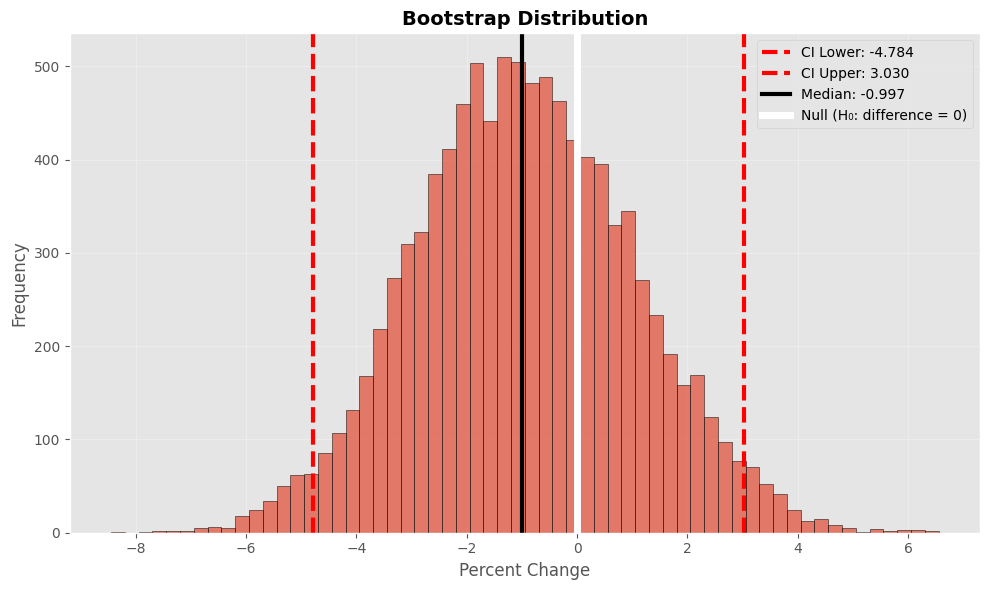

{'p_value': 0.6246,
 'statistic_value': -0.9260739666923988,
 'confidence_interval': array([-4.783873  ,  3.02977635]),
 'distribution': None}

In [12]:
stats = fb.spotify_two_sample_bootstrap(
    sample_1, sample_2, statistic=fb.percent_change, plot=True
)
p_value = stats["p_value"]
stats

In [13]:
fb.display_significance_result(p_value)

<div class="alert alert-block alert-danger">Difference is non-not significant (p-value >= 0.05)</div>

#### Experiment 1.2

QQ-Difference Estimation Plot

In [14]:
fb.quantile_bootstrap_plot(sample_1, sample_2, n_step=1000)

In [15]:
sample_1 = np.random.normal(loc=0, scale=1, size=10000)
sample_2 = np.random.normal(loc=0.1, scale=1.05, size=10000)

In [16]:
fb.quantile_bootstrap_plot(sample_1, sample_2, n_step=1000)

# Experiment 2

Let's model the A/B test experiment with lift in the test sample

In [17]:
# score in test are 10% greater than control (per record)
# control has 5x the number of records as treatment

lift = 1.1
control = np.random.binomial(100, p=0.2 * lift, size=1000) * 1.0
treatment = np.random.binomial(100, p=0.2, size=5000) * 1.0
data_df = pd.concat([pd.Series(treatment), pd.Series(control)], axis=1).rename(
    columns={0: "treatment", 1: "control"}
)

<Axes: ylabel='Count'>

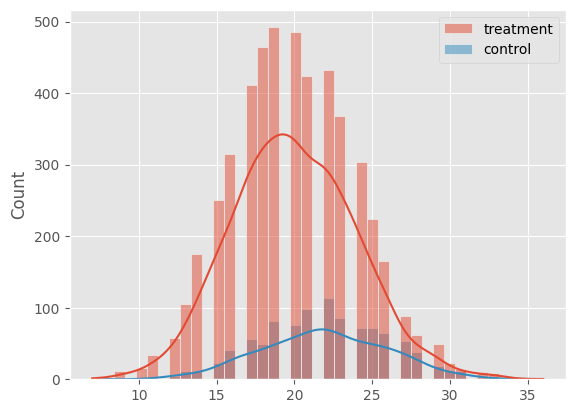

In [18]:
binwidth, bins = fb.estimate_bin_params(treatment)
sns.histplot(data_df, binwidth=binwidth, bins=bins, kde=True)

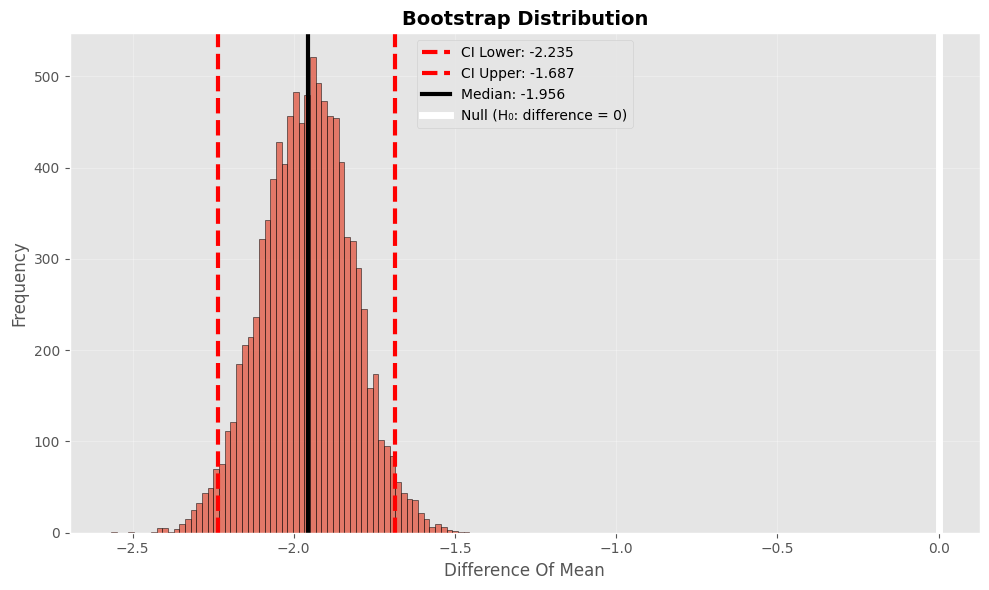

{'p_value': 0.0,
 'statistic_value': -1.956199999999999,
 'confidence_interval': array([-2.235005, -1.6868  ]),
 'distribution': None}

In [19]:
stats = fb.two_sample_bootstrap(control, treatment, plot=True)
p_value = stats["p_value"]
stats

In [20]:
fb.display_significance_result(p_value)

<div class="alert alert-block alert-success">Difference is significant (Result is significant (p-value = 0.0000 < α = 0.05))</div>

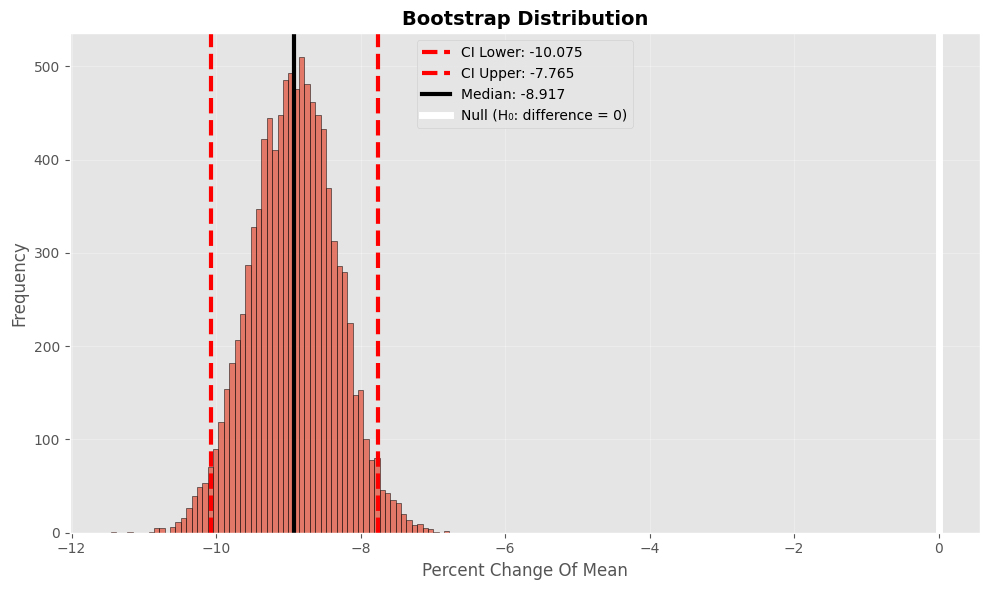

{'p_value': 0.0,
 'statistic_value': -8.91668584018787,
 'confidence_interval': array([-10.07536269,  -7.76478208]),
 'distribution': None}

In [21]:
stats = fb.two_sample_bootstrap(
    control, treatment, statistic=fb.percent_change_of_mean, plot=True
)
p_value = stats["p_value"]
stats

In [22]:
fb.display_significance_result(p_value)

<div class="alert alert-block alert-success">Difference is significant (Result is significant (p-value = 0.0000 < α = 0.05))</div>